In [96]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import xgboost
from xgboost import XGBRegressor

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [97]:
# Load dataset as dataframe
df = pd.read_csv('Traffic_Volume.csv')
df.dropna()
df['holiday'] = df['holiday'].fillna('None')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,None,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,None,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,None,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,None,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [98]:
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')
df['Month'] = df['date_time'].dt.strftime('%B')
df['hour'] = df['date_time'].dt.hour.astype(str)
df['Weekday'] = df['date_time'].dt.strftime('%A')
df = df.drop(columns=['date_time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
 7   Month           48204 non-null  object 
 8   hour            48204 non-null  object 
 9   Weekday         48204 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.7+ MB


In [99]:
# Chat gpt helped condense this

# Loop through each column in the DataFrame
for column in df.columns:
    print(f"Column: {column}")
    if df[column].dtype in ['int64', 'float64', 'int32']:  # For numeric columns
        print(f" - Min Value: {df[column].min()}")
        print(f" - Max Value: {df[column].max()}")
    elif df[column].dtype == 'object':  # For categorical columns
        print(f" - Unique Values: {df[column].nunique()}")
        print(f" - Sample Values: {df[column].unique()}")  # Show up to 5 unique values
    print("-" * 40)  # Separator for better readability

Column: holiday
 - Unique Values: 12
 - Sample Values: ['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']
----------------------------------------
Column: temp
 - Min Value: 0.0
 - Max Value: 310.07
----------------------------------------
Column: rain_1h
 - Min Value: 0.0
 - Max Value: 9831.3
----------------------------------------
Column: snow_1h
 - Min Value: 0.0
 - Max Value: 0.51
----------------------------------------
Column: clouds_all
 - Min Value: 0
 - Max Value: 100
----------------------------------------
Column: weather_main
 - Unique Values: 11
 - Sample Values: ['Clouds' 'Clear' 'Rain' 'Drizzle' 'Mist' 'Haze' 'Fog' 'Thunderstorm'
 'Snow' 'Squall' 'Smoke']
----------------------------------------
Column: traffic_volume
 - Min Value: 0
 - Max Value: 7280
----------------------------------------
Column: Month
 - Unique Value

In [100]:
# Output column for prediction
Y = df['traffic_volume']
X = df.drop(columns = ['traffic_volume'])
features_encoded = pd.get_dummies(X)

features_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,hour_7,hour_8,hour_9,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [101]:
features_encoded.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'holiday_Christmas Day',
       'holiday_Columbus Day', 'holiday_Independence Day', 'holiday_Labor Day',
       'holiday_Martin Luther King Jr Day', 'holiday_Memorial Day',
       'holiday_New Years Day', 'holiday_None', 'holiday_State Fair',
       'holiday_Thanksgiving Day', 'holiday_Veterans Day',
       'holiday_Washingtons Birthday', 'weather_main_Clear',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Haze', 'weather_main_Mist', 'weather_main_Rain',
       'weather_main_Smoke', 'weather_main_Snow', 'weather_main_Squall',
       'weather_main_Thunderstorm', 'Month_April', 'Month_August',
       'Month_December', 'Month_February', 'Month_January', 'Month_July',
       'Month_June', 'Month_March', 'Month_May', 'Month_November',
       'Month_October', 'Month_September', 'hour_0', 'hour_1', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_1

In [102]:
features_encoded.head(10)

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,hour_7,hour_8,hour_9,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5,291.72,0.0,0.0,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6,293.17,0.0,0.0,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7,293.86,0.0,0.0,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8,294.14,0.0,0.0,20,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9,293.10,0.0,0.0,20,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [103]:
train_X, test_X, train_y, test_y = train_test_split(features_encoded, Y, test_size = 0.2, random_state = 1) 

# Defining prediction model
reg = XGBRegressor(random_state = 42)
start = time.time()
# Fitting model on training data
reg.fit(train_X, train_y)
stop = time.time()  
print(f"Training time: {stop - start}s")

Training time: 0.15632414817810059s


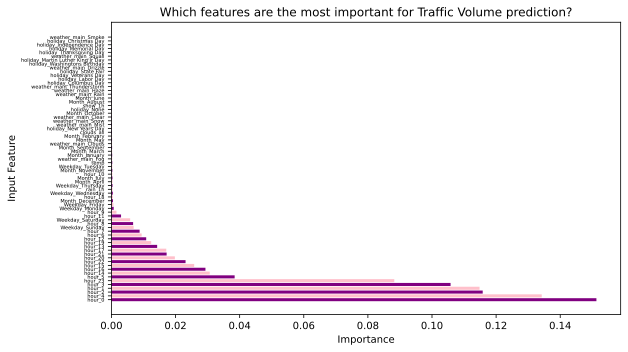

In [104]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['purple', 'pink'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title('Which features are the most important for Traffic Volume prediction?') 
plt.tight_layout()
plt.yticks(fontsize=5)
plt.savefig("feature_xgb_imp.svg");

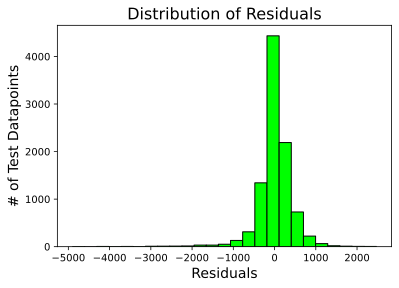

In [105]:
y_pred = reg.predict(test_X)
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("dis_res.svg");

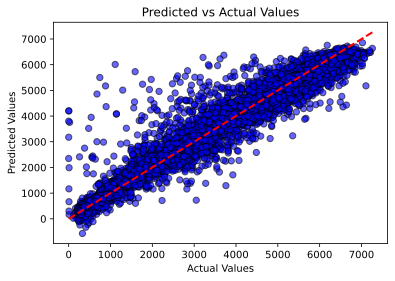

In [106]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("pred_v.svg");

In [107]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 42)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 3.021230936050415s


In [108]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
36845,4720,4407.600098,3799.08,4992.07
9943,3185,2049.459961,1411.65,2607.93
19981,1741,1619.180054,1098.32,2294.71
19918,4611,4597.870117,3968.29,5157.87
28318,4556,4803.839844,4069.31,5366.27


In [109]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.15%


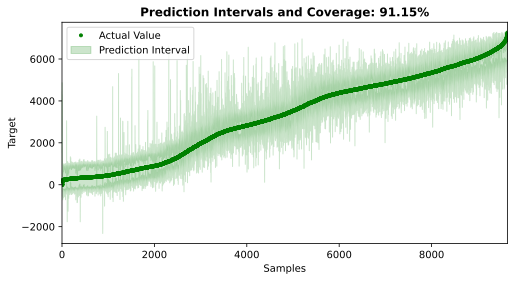

In [110]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10)
plt.savefig("PIAC.svg");

In [111]:
xgb_pickle = open('XGB.pickle', 'wb') 

# Write DT model to the file
pickle.dump(reg, xgb_pickle) 

# Close the file
xgb_pickle.close() 

In [112]:
mapie_pickle = open('MAPIE.pickle', 'wb') 

# Write DT model to the file
pickle.dump(mapie, mapie_pickle) 

# Close the file
mapie_pickle.close() 